# **Ajustar Anchura** 

Esta línea hace que se ajuste la anchura del notebook, por defecto la ajusta a un 92%

In [24]:
# Permite ajustar la anchura de la parte útil de la libreta (reduce los márgenes)
from IPython.display import display, HTML
display(HTML("<style>.container{ width:92% }</style>"))

# **Descargar Dependencias**

Estos son los elementos que se tienen que descargar para un uso adecuado de todo el notebook. 

In [25]:
# !pip install swig
# !pip install wrds
# !pip install pyportfolioopt
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
# !pip install yfinance
# !pip install pandas_market_calendars

# **Se importan las librerías**

In [26]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS

import itertools

# 2. Separar en entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# **Se descargan los datos históricos**

In [27]:
# IMPORTANTE: Las fechas deben seguir el formato 'año/mes/día' (YYYY-MM-DD)
# Estas fechas delimitan el periodo de tiempo del que se descargarán los datos históricos
START_DATE = '2024-01-01'   # Fecha de inicio del análisis
END_DATE = '2025-03-04'     # Fecha de fin del análisis

# Lista de símbolos (tickers) de las acciones que se analizarán
# Estos corresponden a empresas cotizadas en bolsa como Moderna, Nvidia, Uber, etc.
symbols = [
    "MRNA",  # Moderna Inc.
    "NVDA",  # Nvidia Corp.
    "UBER",  # Uber Technologies Inc.
    "ASML",  # ASML Holding N.V.
    "AMZN",  # Amazon.com Inc.
    "AAPL"   # Apple Inc.
]

# Usamos el módulo YahooDownloader de FinRL para descargar datos históricos de acciones
# Se especifica el rango de fechas y la lista de símbolos (acciones) definidos previamente
data = YahooDownloader(
    start_date = START_DATE,   # Fecha de inicio del periodo de análisis
    end_date = END_DATE,       # Fecha de fin del periodo de análisis
    ticker_list = symbols      # Lista de acciones a descargar (AAPL, AMZN, etc.)
).fetch_data()                 # Ejecuta la descarga y devuelve un DataFrame con los datos

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (1752, 8)


# **Extracción de Indicadores Técnicos y Reconstrucción de la Estructura Temporal**

### 1. Extracción de Indicadores Técnicos

Después de descargar los datos históricos de precios para varias acciones, se aplica un proceso de **ingeniería de características** para enriquecer el conjunto de datos con variables útiles para el modelo de aprendizaje automatizado.

Para esto, se utiliza el módulo `FeatureEngineer` de la biblioteca FinRL. Este módulo permite calcular automáticamente varios **indicadores técnicos**, que son ampliamente utilizados en el análisis técnico del mercado bursátil. Estos indicadores ayudan a capturar tendencias, momentum y señales de sobrecompra o sobreventa en los precios.

Entre los indicadores extraídos se encuentran:

- **RSI (Relative Strength Index)**
- **MACD (Moving Average Convergence Divergence)**
- **Bollinger Bands**
- **Medias móviles (SMA, EMA)**
- **CCI, DX, y más**

Además, se incluyen variables adicionales como:

- **VIX**: índice de volatilidad implícita del mercado, útil para medir el "miedo" del mercado.
- **Turbulence**: una medida del comportamiento anómalo del mercado basada en desviaciones multivariadas.

Estos indicadores se calculan para cada acción de forma individual y se agregan como nuevas columnas al DataFrame resultante (`processed`).

---

### 2. Reconstrucción de la estructura fecha × acción

Una vez que se tienen los indicadores técnicos, se realiza un paso adicional: **reconstruir la estructura completa del conjunto de datos**, garantizando que todas las combinaciones posibles de fechas y acciones estén presentes.

#### ¿Por qué se hace esto?

En el mundo real, no todas las acciones tienen datos disponibles para todas las fechas (por ejemplo, por días festivos, suspensiones de cotización o errores en la descarga). Para asegurar que el conjunto de datos sea consistente y estructurado (especialmente útil para modelos temporales), se realiza lo siguiente:

- Se genera una lista completa de fechas entre la mínima y máxima fecha observada.
- Se toma la lista de acciones (tickers) presentes en el conjunto de datos.
- Se calcula el **producto cartesiano** de fechas × acciones, creando todas las combinaciones posibles.
- Este nuevo DataFrame se fusiona con los datos procesados originales para **rellenar los valores existentes** y dejar explícitos los faltantes.
- Finalmente, se filtran las fechas que realmente ocurrieron en el mercado para evitar incluir días como fines de semana o festivos.

Este paso garantiza que el conjunto de datos tenga una estructura rectangular y ordenada, lo cual es especialmente útil para la fase de modelado.

---


In [28]:
# Creamos un objeto FeatureEngineer para calcular automáticamente indicadores técnicos
fe = FeatureEngineer(
    use_technical_indicator=True,        # Activamos el cálculo de indicadores técnicos clásicos (RSI, MACD, etc.)
    tech_indicator_list=INDICATORS,      # Usamos la lista predefinida de indicadores de FinRL
    use_vix=True,                        # Incluye el índice VIX (volatilidad implícita del mercado)
    use_turbulence=True,                 # Incluye la medida de turbulencia financiera
    user_defined_feature=False           # No se agregan indicadores personalizados por ahora
)

# Aplicamos el preprocesamiento sobre el DataFrame descargado ('data') para generar nuevas columnas con indicadores
processed = fe.preprocess_data(data)

# --- Reconstruimos la estructura completa fecha × acción para evitar combinaciones faltantes ---

# Obtenemos la lista única de tickers (acciones)
list_ticker = processed["tic"].unique().tolist()

# Creamos una lista de fechas entre la mínima y máxima fecha disponibles en el dataset
list_date = list(pd.date_range(processed['date'].min(), processed['date'].max()).astype(str))

# Generamos todas las combinaciones posibles de (fecha, ticker)
combination = list(itertools.product(list_date, list_ticker))

# Creamos un nuevo DataFrame con todas las combinaciones posibles (fecha, acción)
# Luego hacemos un left join con los datos procesados para rellenar los datos existentes
processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(
    processed, on=["date", "tic"], how="left"
)

# Filtramos para conservar solo las fechas que realmente estaban en los datos originales
# Esto evita que aparezcan fechas inexistentes (por ejemplo, fines de semana o días festivos)
processed_full = processed_full[processed_full['date'].isin(processed['date'])]

# Ordenamos los datos primero por 'tic' (símbolo de la acción) y luego por 'date'
# Esto es necesario para aplicar el rellenado hacia adelante (forward fill) correctamente dentro de cada acción
processed_full = processed_full.sort_values(['tic', 'date'])

# Rellenamos los valores faltantes con el último valor válido conocido hacia adelante (forward fill)
# Esto es útil porque algunos indicadores técnicos no tienen valor en los primeros días y así evitamos NaNs
processed_full = processed_full = processed_full.ffill()

# Eliminamos cualquier fila que aún tenga valores faltantes después del rellenado
# Esto suele ocurrir en los primeros días de cada acción, donde no hay valores previos para propagar
processed_full = processed_full.dropna()


#OPCIONAL: Visualizar la data
processed_full.head(5)

[*********************100%***********************]  1 of 1 completed


Successfully added technical indicators
Shape of DataFrame:  (291, 8)
Successfully added vix
Successfully added turbulence index


,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2024-01-02,AAPL,184.290405,187.070052,182.553128,185.789422,82488700.0,1.0,0.000000,185.551913,181.649015,0.000000,-66.666667,100.00000,184.290405,184.290405,13.20,0.0
6,2024-01-03,AAPL,182.910522,184.528677,182.096477,182.880742,58414500.0,2.0,-0.030959,185.551913,181.649015,0.000000,-66.666667,100.00000,183.600464,183.600464,14.04,0.0
12,2024-01-04,AAPL,180.587524,181.758939,179.565014,180.825770,71983600.0,3.0,-0.111484,186.338852,178.853449,0.000000,-100.000000,100.00000,182.596151,182.596151,14.13,0.0
18,2024-01-05,AAPL,179.862839,181.431354,178.860187,180.666963,62303300.0,4.0,-0.171540,186.012766,177.812879,0.000000,-77.622807,100.00000,181.912823,181.912823,13.35,0.0
36,2024-01-08,AAPL,184.210999,184.250716,180.180517,180.766224,59144500.0,0.0,-0.027540,186.475194,178.269722,51.361203,26.023231,7.07323,182.372458,182.372458,13.08,0.0


# **Cálculo y Etiquetado de la Volatilidad**

### Parte 1: Cálculo de la Volatilidad de 5 Días

La volatilidad es una medida de qué tanto varían los precios de una acción en un periodo de tiempo. En este caso, la calculamos como la **desviación estándar de los rendimientos diarios** en una ventana móvil de 5 días.

#### ¿Qué se hace?

- Se agrupan los datos por acción (`tic`), ya que la volatilidad debe calcularse de forma independiente para cada activo.
- Se aplica una **ventana móvil de 5 días** sobre la columna `return`, que representa el rendimiento diario.
- Dentro de esa ventana, se calcula la **desviación estándar**, lo cual nos da una estimación local de la volatilidad.
- El resultado se asigna como una nueva columna llamada `volatility_5d`.

#### ¿Por qué usar desviación estándar?

La desviación estándar es una medida clásica de **dispersión estadística**. Cuando los rendimientos de una acción fluctúan mucho en pocos días, la desviación estándar será alta. Por eso, se utiliza como una buena aproximación de la volatilidad en análisis financiero.

---

### Parte 2: Etiquetado de Días con "Alta Volatilidad"

Para usar modelos de clasificación, necesitamos transformar la volatilidad continua en una variable binaria. Lo hacemos creando una etiqueta que indique si un día tiene o no **alta volatilidad**.

#### ¿Qué se hace?

- Se agrupan los datos por acción (`tic`), ya que cada acción puede tener un nivel típico de volatilidad distinto.
- Se calcula el **percentil 75** (también llamado cuartil superior) de la columna `volatility_5d` para cada acción.
- Este valor actúa como un **umbral dinámico**: representa qué tan volátil debe ser un día para ser considerado "alto" en el contexto de esa acción.
- Para cada fila, se compara la volatilidad observada con ese umbral:
  - Si la volatilidad es mayor al percentil 75 → se etiqueta como `1` (alta volatilidad).
  - Si es menor o igual → se etiqueta como `0` (baja o normal volatilidad).
- El resultado se almacena en una nueva columna llamada `volatilidad_alta`.

---

#### ¿Qué es el percentil 75 y por qué se usa?

El percentil 75 es el valor por debajo del cual se encuentra el 75% de los datos. En este caso, representa un umbral de volatilidad "alta" relativo al comportamiento típico de cada acción. Si la volatilidad de un día supera este valor, se considera un evento inusualmente volátil. Esta estrategia permite adaptar el criterio de alta volatilidad a cada acción, en lugar de usar un valor fijo para todas.


In [29]:
# 1. Ordenamos por acción y fecha
processed_full = processed_full.sort_values(['tic', 'date'])

# 2. Calculamos el rendimiento diario por acción
processed_full['return'] = processed_full.groupby('tic')['close'].pct_change()

# 3. Calculamos la volatilidad como desviación estándar de 5 días sobre los rendimientos
processed_full['volatility_5d'] = processed_full.groupby('tic')['return'].rolling(5).std().reset_index(0, drop=True)

# 4. Etiquetamos los días con volatilidad alta (top 25% por acción)
def etiquetar_volatilidad(df, column='volatility_5d'):
    umbrales = df.groupby('tic')[column].transform(lambda x: x.quantile(0.75))
    df['volatilidad_alta'] = (df[column] > umbrales).astype(int)
    return df

processed_full = etiquetar_volatilidad(processed_full)

# 5. Eliminamos filas con valores faltantes
processed_full = processed_full.dropna()

processed_full

,date,tic,close,high,low,open,volume,day,macd,boll_ub,...,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,return,volatility_5d,volatilidad_alta
42,2024-01-09,AAPL,183.794052,183.803974,181.401569,182.582920,42841800.0,1.0,0.041713,186.458188,...,48.871275,29.331192,7.073230,182.609390,182.609390,12.760000,0.000000,-0.002263,0.014335,0
48,2024-01-10,AAPL,184.836411,185.044875,182.582909,183.009791,46792900.0,2.0,0.132628,186.823487,...,54.567398,76.253578,13.208381,182.927536,182.927536,12.690000,0.000000,0.005671,0.013924,0
54,2024-01-11,AAPL,184.240768,185.690161,182.285089,185.183859,49128400.0,3.0,0.163128,186.816254,...,51.195767,66.899707,21.476378,183.091690,183.091690,12.440000,0.000000,-0.003223,0.011889,0
60,2024-01-12,AAPL,184.568375,185.382421,183.843686,184.707356,40444700.0,4.0,0.198020,186.876192,...,52.853248,85.517758,21.476378,183.255766,183.255766,12.700000,0.000000,0.001778,0.011165,0
84,2024-01-16,AAPL,182.295029,182.920438,179.614645,180.835714,65603000.0,1.0,0.102792,186.626723,...,42.493480,-66.785021,29.102601,183.159692,183.159692,13.840000,0.000000,-0.012317,0.006729,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2519,2025-02-24,UBER,76.419998,78.879997,74.849998,78.650002,24368400.0,0.0,3.449048,86.061833,...,56.159591,65.676325,7.593468,71.628999,68.240166,18.980000,4.777465,-0.031309,0.023722,0
2525,2025-02-25,UBER,74.949997,76.370003,73.529999,76.360001,19559200.0,1.0,3.006083,86.140179,...,54.305930,39.701343,12.923284,71.928332,68.265666,19.430000,1.501326,-0.019236,0.014634,0
2531,2025-02-26,UBER,75.870003,76.489998,75.309998,75.330002,10328900.0,2.0,2.698164,86.198854,...,55.261977,47.506516,12.293895,72.267332,68.337499,19.100000,6.419844,0.012275,0.019213,0
2537,2025-02-27,UBER,74.209999,77.690002,73.709999,75.949997,22535900.0,3.0,2.293746,85.983300,...,53.184914,35.376200,18.748735,72.579666,68.380666,21.129999,9.438051,-0.021880,0.017570,0


# **Descripción de las columnas del dataset final (`data_para_modelo.csv`)**

A continuación se describen brevemente las columnas del conjunto de datos que se utilizará para entrenar los modelos de clasificación:

- **close**: Precio de cierre de la acción en el día correspondiente.
- **high**: Precio más alto alcanzado por la acción durante el día.
- **low**: Precio más bajo alcanzado por la acción durante el día.
- **open**: Precio de apertura de la acción en ese día.
- **volume**: Volumen de operaciones (cantidad de acciones intercambiadas en el día).
- **day**: Día de la semana representado como número (0 = lunes, 6 = domingo).

### Indicadores técnicos (features extraídas automáticamente):
- **macd**: Media móvil de convergencia/divergencia, indicador de momentum.
- **boll_ub** / **boll_lb**: Bandas de Bollinger superior e inferior, usadas para detectar sobrecompra o sobreventa.
- **rsi_30**: Índice de fuerza relativa (RSI) con ventana de 30 días.
- **cci_30**: Commodity Channel Index, mide la variación del precio respecto a su media.
- **dx_30**: Directional Movement Index, evalúa la fuerza de una tendencia.
- **close_30_sma** / **close_60_sma**: Medias móviles simples del precio de cierre en ventanas de 30 y 60 días.

### Etiqueta (target):
- **volatilidad_alta**: Variable binaria que indica si el día fue clasificado como de alta volatilidad (`1`) o no (`0`), calculado con base en el percentil 75 de la volatilidad histórica por acción.

---


In [30]:
# Opcional: inspeccionar columnas
print(processed_full.columns)

# Definir columnas a excluir
columnas_excluir = ['date', 'tic', 'return', 'volatility_5d']

# Crear DataFrame solo con features + target
df_model = processed_full.drop(columns=columnas_excluir, errors='ignore')

# Acomodar columnas para dejar 'volatilidad_alta' al final (opcional, por claridad)
columnas = [col for col in df_model.columns if col != 'volatilidad_alta'] + ['volatilidad_alta']
df_model = df_model[columnas]

Index(['date', 'tic', 'close', 'high', 'low', 'open', 'volume', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma',
       'close_60_sma', 'vix', 'turbulence', 'return', 'volatility_5d',
       'volatilidad_alta'],
      dtype='object')


In [31]:
df_model

,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,volatilidad_alta
42,183.794052,183.803974,181.401569,182.582920,42841800.0,1.0,0.041713,186.458188,178.760593,48.871275,29.331192,7.073230,182.609390,182.609390,12.760000,0.000000,0
48,184.836411,185.044875,182.582909,183.009791,46792900.0,2.0,0.132628,186.823487,179.031585,54.567398,76.253578,13.208381,182.927536,182.927536,12.690000,0.000000,0
54,184.240768,185.690161,182.285089,185.183859,49128400.0,3.0,0.163128,186.816254,179.367126,51.195767,66.899707,21.476378,183.091690,183.091690,12.440000,0.000000,0
60,184.568375,185.382421,183.843686,184.707356,40444700.0,4.0,0.198020,186.876192,179.635340,52.853248,85.517758,21.476378,183.255766,183.255766,12.700000,0.000000,0
84,182.295029,182.920438,179.614645,180.835714,65603000.0,1.0,0.102792,186.626723,179.692661,42.493480,-66.785021,29.102601,183.159692,183.159692,13.840000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2519,76.419998,78.879997,74.849998,78.650002,24368400.0,0.0,3.449048,86.061833,61.638165,56.159591,65.676325,7.593468,71.628999,68.240166,18.980000,4.777465,0
2525,74.949997,76.370003,73.529999,76.360001,19559200.0,1.0,3.006083,86.140179,62.177820,54.305930,39.701343,12.923284,71.928332,68.265666,19.430000,1.501326,0
2531,75.870003,76.489998,75.309998,75.330002,10328900.0,2.0,2.698164,86.198854,62.899145,55.261977,47.506516,12.293895,72.267332,68.337499,19.100000,6.419844,0
2537,74.209999,77.690002,73.709999,75.949997,22535900.0,3.0,2.293746,85.983300,63.860699,53.184914,35.376200,18.748735,72.579666,68.380666,21.129999,9.438051,0


## **Opcional**

Se guarda la data ya preprocesada

In [32]:
# df_model.to_csv("data_para_modelo.csv", index=False)
# print("Archivo 'data_para_modelo.csv' guardado correctamente.")

# **Escalarización de los datos**

In [33]:
# 1. Separar X (características) e y (etiqueta)
# Excluimos la columna 'volatilidad_alta' de X porque es la variable que queremos predecir
X = df_model.drop(columns=['volatilidad_alta'])
y = df_model['volatilidad_alta']

# 2. Dividir el conjunto en entrenamiento (80%) y prueba (20%)
# Usamos shuffle=False porque los datos son temporales (series de tiempo) y no deben mezclarse
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Escalar las características
# Aplicamos StandardScaler para llevar todas las columnas numéricas a media 0 y desviación estándar 1
# Ajustamos el escalador con los datos de entrenamiento y luego transformamos ambos conjuntos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Reconstruir el DataFrame escalado completo (entrenamiento + prueba)
# Unimos ambos arrays escalados y los convertimos a un DataFrame con los mismos nombres de columnas originales
X_scaled = pd.DataFrame(
    np.concatenate([X_train_scaled, X_test_scaled]),
    columns=X.columns
)

# 5. Añadir la columna de etiqueta (volatilidad alta) al DataFrame escalado
# Concatenamos las etiquetas originales (y_train + y_test) y las alineamos con los datos escalados
X_scaled['volatilidad_alta'] = pd.concat([y_train, y_test]).reset_index(drop=True)

# 6. OPCIONAL: Guardar el DataFrame completo escalado como CSV
# X_scaled.to_csv("data_escalada.csv", index=False)
# print("Archivo 'data_escalada.csv' guardado correctamente.")

# **Análisis de la Distribución de Clases**

Antes de entrenar cualquier modelo, es importante revisar cuántos ejemplos pertenecen a cada clase en la variable objetivo `volatilidad_alta`. Para esto, se contabilizó el número y el porcentaje de ejemplos con:

- `0`: días de baja o normal volatilidad
- `1`: días de alta volatilidad

### ¿Por qué tiene sentido?

La etiqueta `volatilidad_alta` se construyó usando el **percentil 75** de la volatilidad histórica de cada acción. Esto significa que, por diseño, **aproximadamente el 25%** de los días más volátiles fueron etiquetados como `1` (alta volatilidad), y el **75% restante** como `0` (normal o baja volatilidad).

Esto explica que la distribución de clases no sea balanceada al 50%, sino más cercana a una proporción 75/25, lo cual es esperable y coherente con el criterio de etiquetado aplicado.

Esta revisión también permite tomar decisiones informadas sobre métricas de evaluación (como F1-score) y, si fuera necesario, aplicar técnicas de balanceo o ajuste de pesos durante el entrenamiento.


In [34]:
print("-"*50)
# Contar cuántas veces aparece cada clase (0 o 1) en la columna 'volatilidad_alta'
# Esto nos dice cuántos ejemplos hay de días con baja/normal volatilidad (0) y de alta volatilidad (1)
conteo_clases = X_scaled['volatilidad_alta'].value_counts()

# Mostramos el número total de ejemplos por clase
print(conteo_clases)

print("-"*50)
# Calculamos el porcentaje que representa cada clase respecto al total
# normalize=True hace que los resultados estén entre 0 y 1, y luego se multiplican por 100 para expresarlos como porcentaje
porcentaje_clases = X_scaled['volatilidad_alta'].value_counts(normalize=True) * 100

# Mostramos el porcentaje de cada clase (útil para entender el balance del dataset)
print(porcentaje_clases)
print("-"*50)

--------------------------------------------------
volatilidad_alta
0    1284
1     432
Name: count, dtype: int64
--------------------------------------------------
volatilidad_alta
0    74.825175
1    25.174825
Name: proportion, dtype: float64
--------------------------------------------------


# **Entrenamiento de los modelos**

## AWAAAAASS

La data ya fue preprocesada, escalada y dividida. Puedes empezar directamente a entrenar modelos de clasificación con los siguientes conjuntos:

- `X_train_scaled`: datos de entrenamiento escalados
- `X_test_scaled`: datos de prueba escalados
- `y_train`: etiquetas correspondientes a `X_train_scaled`
- `y_test`: etiquetas correspondientes a `X_test_scaled`

Todos los datos han sido escalados con `StandardScaler()` y ordenados sin mezclar (`shuffle=False`), respetando su naturaleza temporal.

Puedes usar estos conjuntos para probar modelos como:
- Random Forest
- Logistic Regression
- SVM
- Redes neuronales (MLP)

## Función para evaluar los modelos uwu
Es más fácil hacer una función para que cada modelo se evalúe y se siga exactamente el mismo procedimiento cada vez, esta sección se dedica a eso. 

Recibe los siguientes parámetros:
* modelo: instancia del modelo (por ejemplo RandomForestClassifier()).
* nombre: string con el nombre del modelo.
* X_train, y_train: conjunto de entrenamiento.
* X_test, y_test: conjunto de prueba.
* mostrar_roc: si True, grafica la curva ROC (si es posible).

Y regresa:
* Presición del modelo
* Reporte de clasificación
* Matriz de confusión
* Curva ROC

In [35]:
# azul
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def evaluar_modelo(modelo, nombre, X_train, y_train, X_test, y_test, mostrar_roc=True):
    """
    Entrena y evalúa un modelo de clasificación.

    Parámetros:
        modelo: instancia del modelo (por ejemplo RandomForestClassifier()).
        nombre: string con el nombre del modelo.
        X_train, y_train: conjunto de entrenamiento.
        X_test, y_test: conjunto de prueba.
        mostrar_roc: si True, grafica la curva ROC (si es posible).
    """
    
    print(f"\nEvaluando modelo: {nombre}...")
    
    # Entrenamiento
    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)

    # Métricas
    print("Precisión del modelo:", round(accuracy_score(y_test, y_pred), 4))
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=["No Volátil", "Alta Volatilidad"]))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Volátil", "Alta Volatilidad"],
                yticklabels=["No Volátil", "Alta Volatilidad"])
    plt.xlabel("Predicción")
    plt.ylabel("Verdadero")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

    # Curva ROC
    if mostrar_roc and hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{nombre} (AUC = {auc:.2f})")
        plt.plot([0, 1], [0, 1], "--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre}")
        plt.legend()
        plt.grid(True)
        plt.show()


Evaluando modelo: Random Forest...
Precisión del modelo: 0.7384

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.80      0.88      0.84       260
Alta Volatilidad       0.45      0.30      0.36        84

        accuracy                           0.74       344
       macro avg       0.62      0.59      0.60       344
    weighted avg       0.71      0.74      0.72       344



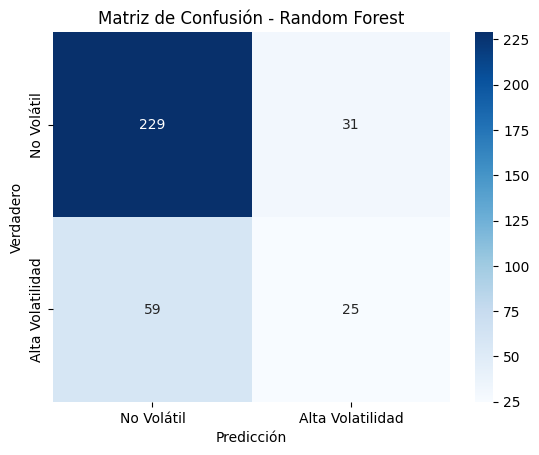

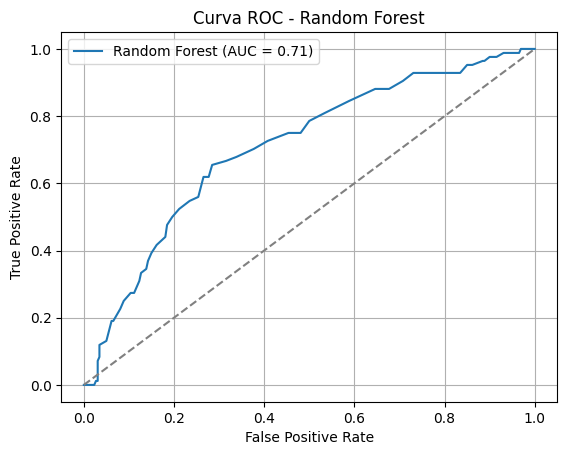


Evaluando modelo: Regresión Logística...
Precisión del modelo: 0.7645

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.77      0.98      0.86       260
Alta Volatilidad       0.62      0.10      0.16        84

        accuracy                           0.76       344
       macro avg       0.69      0.54      0.51       344
    weighted avg       0.73      0.76      0.69       344



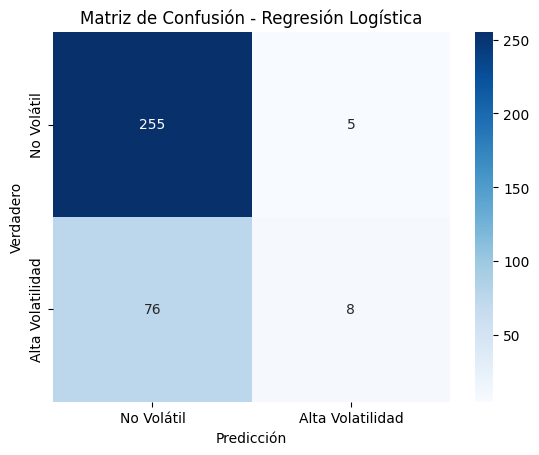

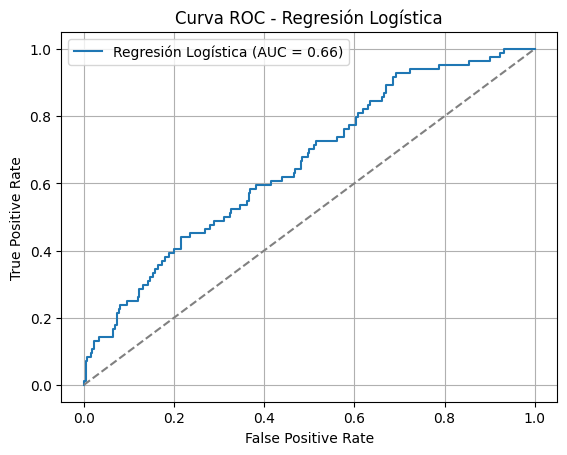


Evaluando modelo: XGBoost...
Precisión del modelo: 0.7064

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.80      0.81      0.81       260
Alta Volatilidad       0.40      0.39      0.40        84

        accuracy                           0.71       344
       macro avg       0.60      0.60      0.60       344
    weighted avg       0.71      0.71      0.71       344



/Users/elizabethra/Documents/Académico/2025-2/AprendizajeAutomatizado/Proyecto/EntornoML/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:11:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


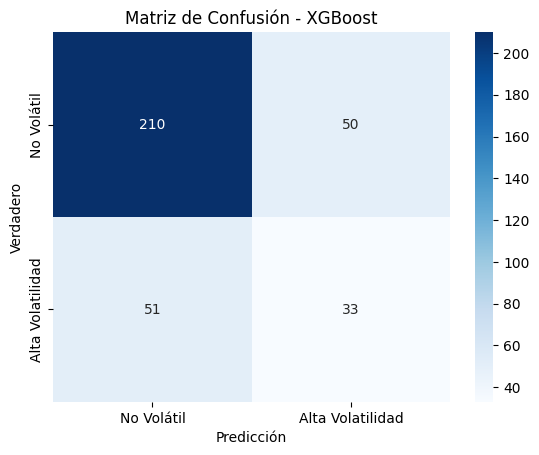

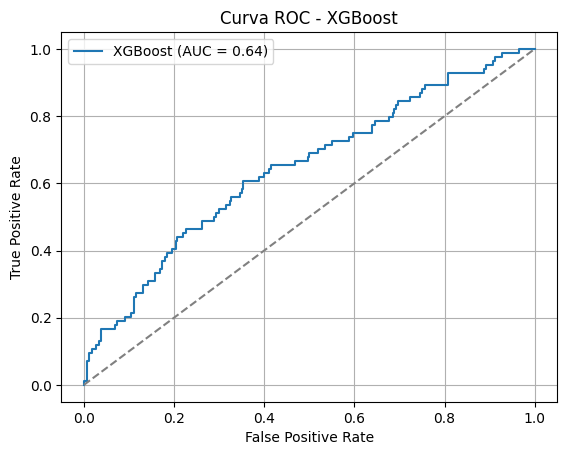


Evaluando modelo: SVM...
Precisión del modelo: 0.7587

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.78      0.95      0.86       260
Alta Volatilidad       0.52      0.17      0.25        84

        accuracy                           0.76       344
       macro avg       0.65      0.56      0.55       344
    weighted avg       0.72      0.76      0.71       344



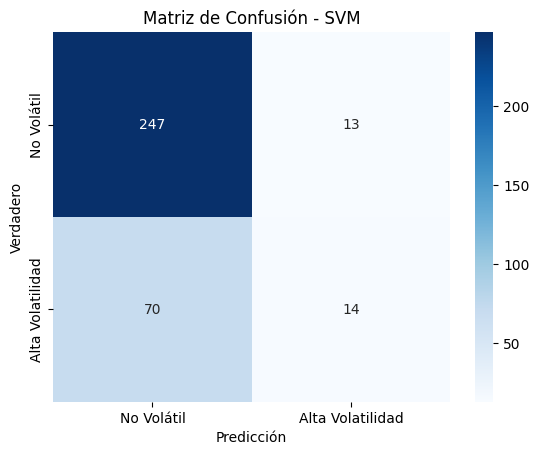

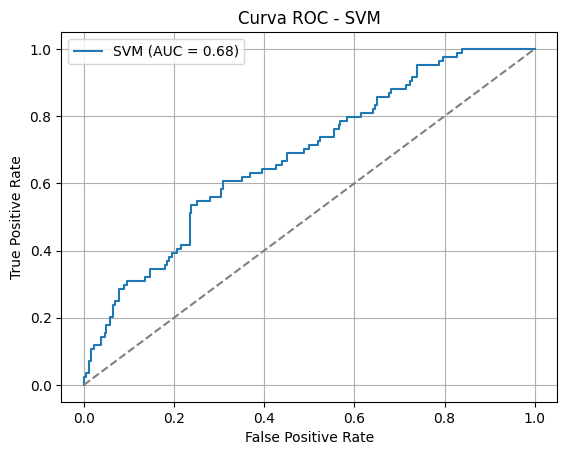


Evaluando modelo: K-Nearest Neighbors...
Precisión del modelo: 0.7006

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.77      0.86      0.81       260
Alta Volatilidad       0.33      0.21      0.26        84

        accuracy                           0.70       344
       macro avg       0.55      0.54      0.54       344
    weighted avg       0.66      0.70      0.68       344



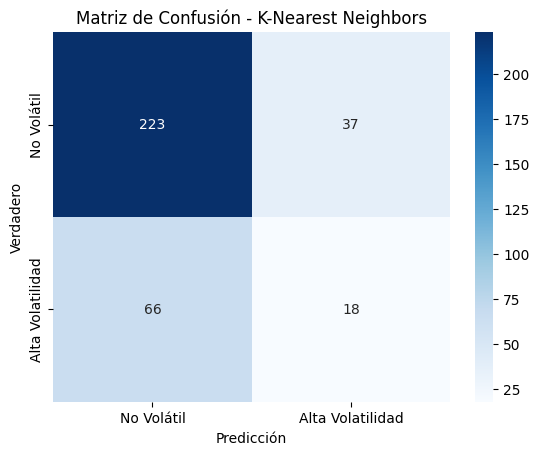

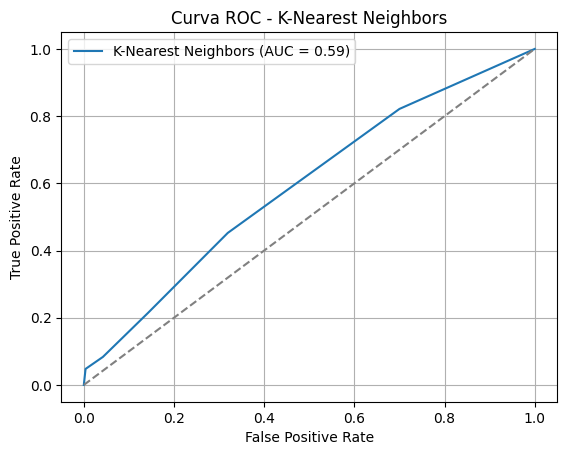

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Random Forest
evaluar_modelo(RandomForestClassifier(random_state=42), "Random Forest", X_train_scaled, y_train, X_test_scaled, y_test)

# Regresión Logística
evaluar_modelo(LogisticRegression(max_iter=500), "Regresión Logística", X_train_scaled, y_train, X_test_scaled, y_test)

# XGBoost
evaluar_modelo(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), "XGBoost", X_train_scaled, y_train, X_test_scaled, y_test)

# SVM
from sklearn.svm import SVC
evaluar_modelo(SVC(probability=True, random_state=42), "SVM", X_train_scaled, y_train, X_test_scaled, y_test)

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
evaluar_modelo(KNeighborsClassifier(), "K-Nearest Neighbors", X_train_scaled, y_train, X_test_scaled, y_test)

## Pero... ¿cómo se maneja la concurrencia?

En los modelos anteriores no se hace. Ordenamos los datos primero por ticker y luego por fecha para después etiquetar cada renglón. Sin embargo, los modelos tradicionales no consideran que cada dato está relacionado con otros por el *tiempo* y tratan a cada renglón de información como algo independiente. 

Esto puede afectar nuestros resultados porque se pierde la dependencia temporal: un modelo que ignora lo que ocurrió en los días previos puede tener más dificultad para detectar patrones que se desarrollan a lo largo del tiempo, como una racha de alta volatilidad o una reversión de tendencia.

Para evaluar el impacto de esta limitación, decidimos explorar dos acercamientos:

### 1. Agregar columnas que reflejen eventos del pasado

Este método consiste en incorporar información histórica dentro de cada renglón, lo cual permite a los modelos tradicionales “ver hacia atrás” sin necesidad de modificar su estructura.

Para cada día y acción (`ticker`), se agregan nuevas columnas que contienen valores de días anteriores, tales como:

- Rendimientos: `return_t-1`, `return_t-2`, ..., `return_t-5`
- Precio de cierre: `close_t-1`, ..., `close_t-5`
- Volatilidad reciente: `volatility_5d_t-1`, ...
- Indicadores técnicos desfasados (como RSI o medias móviles)

De esta manera, aunque el modelo sigue tratando cada fila como una observación independiente, ahora esa observación incluye un resumen del comportamiento reciente del activo.

Decidimos hacer esto porque es fácil de implementar, es compatible con los modelos ya entrenados y nos permite evaluar cuánto mejora el desempeño al incorporar memoria explícita como nuevas *features*.
te quiero Daniii <3
### 2. Red Neuronal Recurrente (RNN / LSTM)

En este segundo acercamiento utilizamos un modelo que fue **diseñado específicamente para datos secuenciales**. Las Redes Neuronales Recurrentes (RNN), y en particular sus variantes como LSTM (Long Short-Term Memory), procesan secuencias de datos paso a paso, manteniendo un estado interno que les permite “recordar” eventos pasados.

Cada muestra que se le da al modelo ya no es un solo día, sino una **secuencia de días anteriores**. Por ejemplo, podríamos usar los últimos 10 días de precios, rendimientos e indicadores técnicos como entrada, y pedirle al modelo que prediga si el día siguiente será de alta volatilidad.

Decidimos hacer esto porque captura dinámicas temporales complejas (como patrones de comportamiento que se extienden en varios días), tiene memoria interna (a diferencia de los modelos clásicos)y es más expresivo para problemas donde el *contexto histórico* importa.

---
Ambos acercamientos nos permiten evaluar **cómo impacta la recurrencia en la predicción de volatilidad**: el primero de manera implícita, y el segundo de forma explícita. Esta comparación nos ayuda a entender qué tan importante es la información histórica en nuestro problema, y qué técnicas son más efectivas para aprovecharla.

In [37]:
# la misma función de evaluación que usamos antes, pero con un color diferente para la matriz de confusión pq quiero que se puedan distinguir
# moradito
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def evaluar_modelo(modelo, nombre, X_train, y_train, X_test, y_test, mostrar_roc=True):
    """
    Entrena y evalúa un modelo de clasificación.

    Parámetros:
        modelo: instancia del modelo (por ejemplo RandomForestClassifier()).
        nombre: string con el nombre del modelo.
        X_train, y_train: conjunto de entrenamiento.
        X_test, y_test: conjunto de prueba.
        mostrar_roc: si True, grafica la curva ROC (si es posible).
    """
    
    print(f"\nEvaluando modelo: {nombre}...")
    
    # Entrenamiento
    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)

    # Métricas
    print("Precisión del modelo:", round(accuracy_score(y_test, y_pred), 4))
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=["No Volátil", "Alta Volatilidad"]))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=["No Volátil", "Alta Volatilidad"],
                yticklabels=["No Volátil", "Alta Volatilidad"])
    plt.xlabel("Predicción")
    plt.ylabel("Verdadero")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

    # Curva ROC
    if mostrar_roc and hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{nombre} (AUC = {auc:.2f})", color='purple')
        plt.plot([0, 1], [0, 1], "--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre}")
        plt.legend()
        plt.grid(True)
        plt.show()

### 1. Agregar columnas que reflejen eventos del pasadoRegresaremos a la base `processed_full`.

In [38]:
# Número de días hacia atrás que queremos incluir
n_lags = 5

# Columnas a desfazar (lag)
columnas_lag = ['return', 'volatility_5d']  # o lo que hayas calculado

# Aplicar para cada acción individualmente
for col in columnas_lag:
    for lag in range(1, n_lags + 1):
        processed_full[f"{col}_t-{lag}"] = (
            processed_full
            .groupby("tic")[col]
            .shift(lag)
        )

# Eliminar filas con valores faltantes por los lags
processed_lagged = processed_full.dropna().reset_index(drop=True)

In [39]:
processed_lagged.head(5)

,date,tic,close,high,low,open,volume,day,macd,boll_ub,...,return_t-1,return_t-2,return_t-3,return_t-4,return_t-5,volatility_5d_t-1,volatility_5d_t-2,volatility_5d_t-3,volatility_5d_t-4,volatility_5d_t-5
0,2024-01-17,AAPL,181.351913,181.600096,178.989226,179.952176,47317400.0,2.0,-0.017708,186.460412,...,-0.012317,0.001778,-0.003223,0.005671,-0.002263,0.006729,0.011165,0.011889,0.013924,0.014335
1,2024-01-18,AAPL,187.258698,187.764984,184.479050,184.737154,78005800.0,3.0,0.218654,187.470562,...,-0.005174,-0.012317,0.001778,-0.003223,0.005671,0.006874,0.006729,0.011165,0.011889,0.013924
2,2024-01-19,AAPL,190.167374,190.554538,187.447303,187.953590,68741000.0,4.0,0.555352,189.339169,...,0.032571,-0.005174,-0.012317,0.001778,-0.003223,0.017433,0.006874,0.006729,0.011165,0.011889
3,2024-01-22,AAPL,192.480453,193.909987,190.862298,190.902016,60133900.0,0.0,0.934219,191.469553,...,0.015533,0.032571,-0.005174,-0.012317,0.001778,0.017846,0.017433,0.006874,0.006729,0.011165
4,2024-01-23,AAPL,193.761047,194.326911,192.420871,193.602222,42355600.0,1.0,1.284014,193.363736,...,0.012163,0.015533,0.032571,-0.005174,-0.012317,0.017766,0.017846,0.017433,0.006874,0.006729


In [40]:
processed_lagged.columns

Index(['date', 'tic', 'close', 'high', 'low', 'open', 'volume', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma',
       'close_60_sma', 'vix', 'turbulence', 'return', 'volatility_5d',
       'volatilidad_alta', 'return_t-1', 'return_t-2', 'return_t-3',
       'return_t-4', 'return_t-5', 'volatility_5d_t-1', 'volatility_5d_t-2',
       'volatility_5d_t-3', 'volatility_5d_t-4', 'volatility_5d_t-5'],
      dtype='object')

In [41]:
# Eliminar columnas que no queremos usar como entrada
columnas_excluir = ['date', 'tic', 'return', 'volatility_5d']
df_model_lagged = processed_lagged.drop(columns=columnas_excluir, errors='ignore')

# Reordenar columnas para poner el target al final
columnas = [col for col in df_model_lagged.columns if col != 'volatilidad_alta'] + ['volatilidad_alta']
df_model_lagged = df_model_lagged[columnas]

In [42]:
# Entrada y salida
X = df_model_lagged.drop(columns=['volatilidad_alta'])
y = df_model_lagged['volatilidad_alta']

from sklearn.model_selection import train_test_split

# División antes de escalar
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

from sklearn.preprocessing import StandardScaler

# Escalamiento correcto
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Evaluando modelo: Random Forest...
Precisión del modelo: 0.8876

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.91      0.95      0.93       252
Alta Volatilidad       0.82      0.71      0.76        86

        accuracy                           0.89       338
       macro avg       0.86      0.83      0.84       338
    weighted avg       0.88      0.89      0.88       338



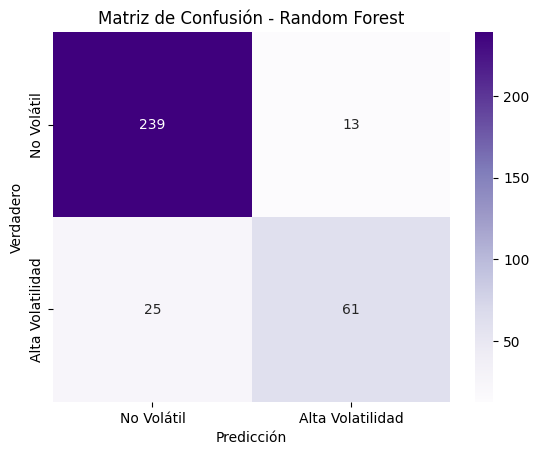

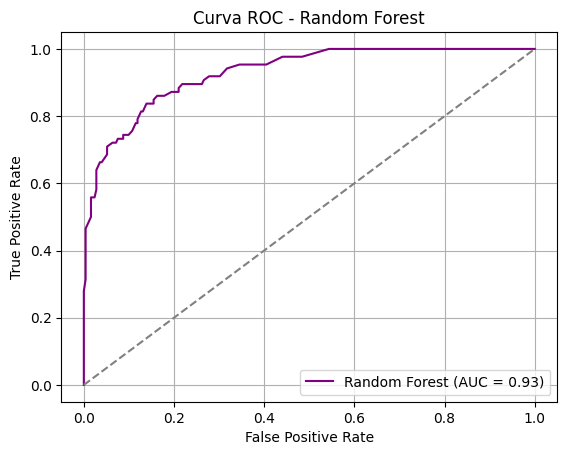


Evaluando modelo: Regresión Logística...
Precisión del modelo: 0.8166

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.85      0.92      0.88       252
Alta Volatilidad       0.69      0.51      0.59        86

        accuracy                           0.82       338
       macro avg       0.77      0.72      0.73       338
    weighted avg       0.81      0.82      0.81       338



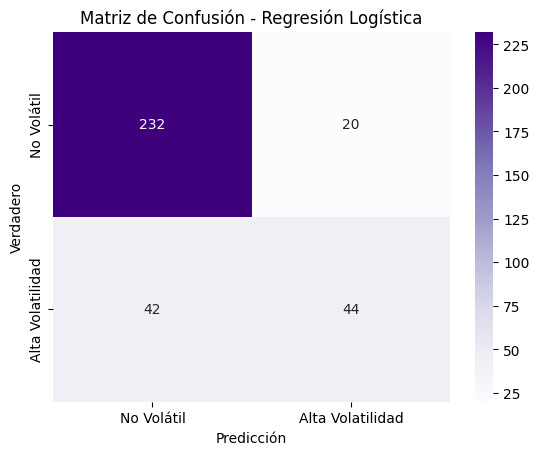

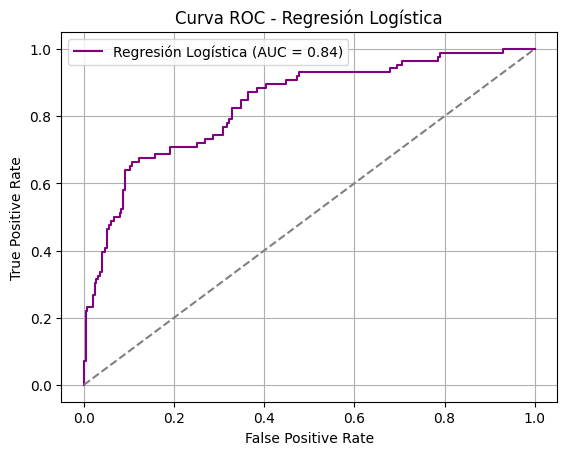


Evaluando modelo: XGBoost...
Precisión del modelo: 0.8994

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.91      0.96      0.93       252
Alta Volatilidad       0.87      0.71      0.78        86

        accuracy                           0.90       338
       macro avg       0.89      0.84      0.86       338
    weighted avg       0.90      0.90      0.90       338



/Users/elizabethra/Documents/Académico/2025-2/AprendizajeAutomatizado/Proyecto/EntornoML/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:11:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


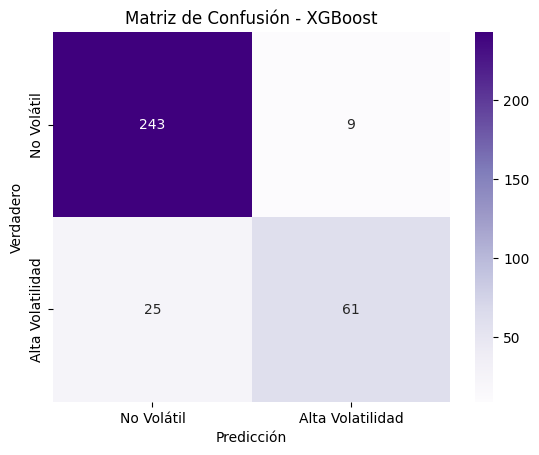

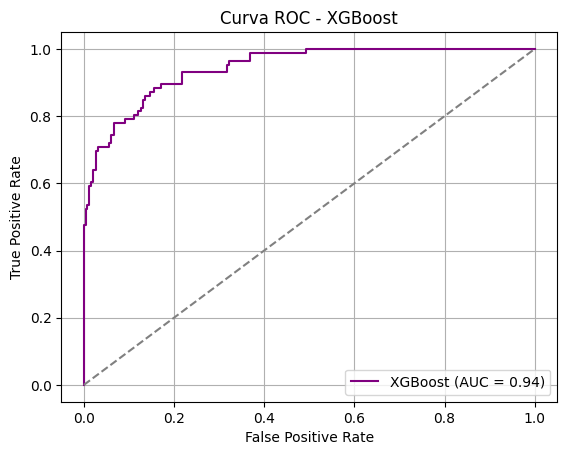


Evaluando modelo: SVM...
Precisión del modelo: 0.8314

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.84      0.95      0.89       252
Alta Volatilidad       0.77      0.48      0.59        86

        accuracy                           0.83       338
       macro avg       0.81      0.71      0.74       338
    weighted avg       0.82      0.83      0.82       338



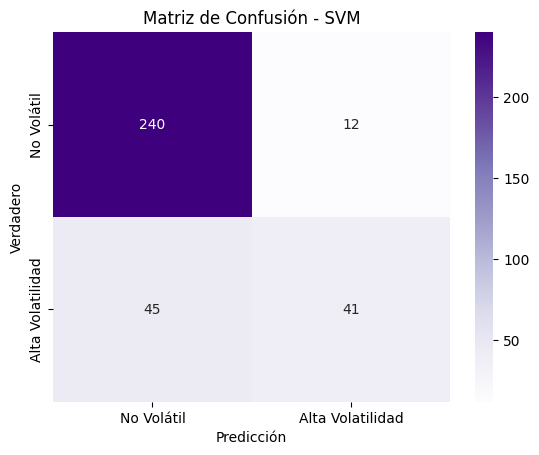

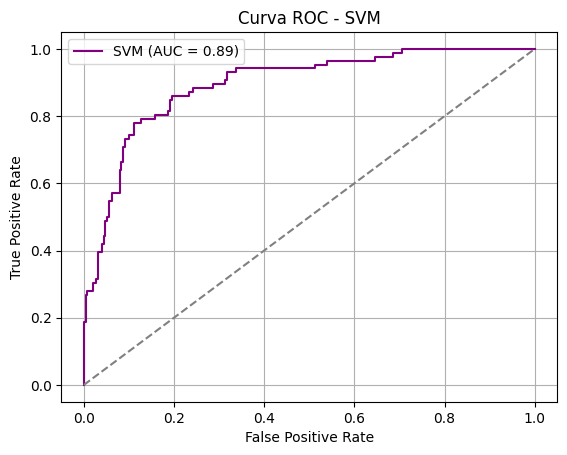


Evaluando modelo: K-Nearest Neighbors...
Precisión del modelo: 0.8254

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.82      0.98      0.89       252
Alta Volatilidad       0.85      0.38      0.53        86

        accuracy                           0.83       338
       macro avg       0.83      0.68      0.71       338
    weighted avg       0.83      0.83      0.80       338



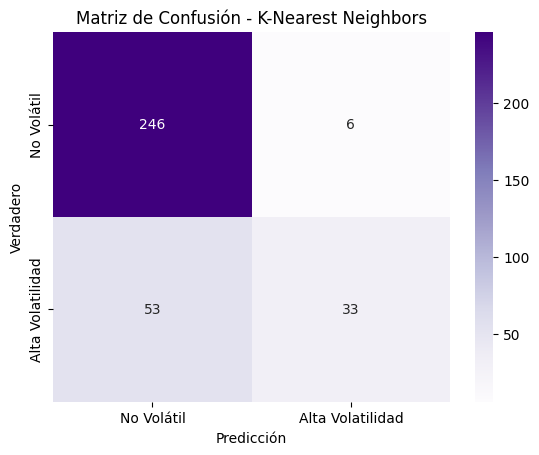

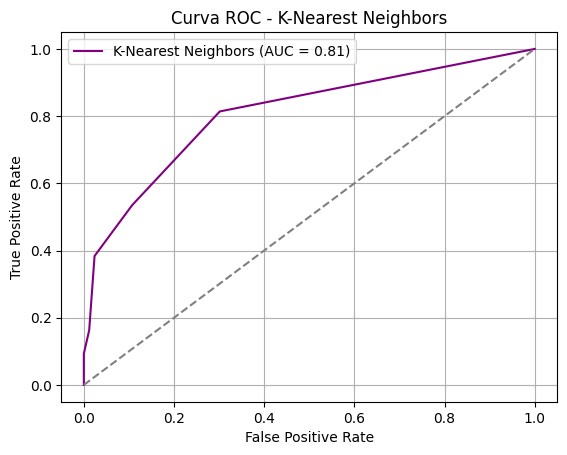

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Random Forest
evaluar_modelo(RandomForestClassifier(random_state=42), "Random Forest", X_train_scaled, y_train, X_test_scaled, y_test)

# Regresión Logística
evaluar_modelo(LogisticRegression(max_iter=500), "Regresión Logística", X_train_scaled, y_train, X_test_scaled, y_test)

# XGBoost
evaluar_modelo(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), "XGBoost", X_train_scaled, y_train, X_test_scaled, y_test)

# SVM
evaluar_modelo(SVC(probability=True, random_state=42), "SVM", X_train_scaled, y_train, X_test_scaled, y_test)

# K-Nearest Neighbors
evaluar_modelo(KNeighborsClassifier(), "K-Nearest Neighbors", X_train_scaled, y_train, X_test_scaled, y_test)